In [2]:
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display

## Open up GPA data

In [3]:
gpa_data_raw = pd.read_csv("data/FR_GPA_by_Inst_data_converted.csv")
gpa_data_raw.head()

,Calculation1,Campus,City,County,Fall Term,Measure Names,School,Measure Values
0,21ST CENTURY EXPERIMENTAL SCH694223,Santa Cruz,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
1,21ST CENTURY EXPERIMENTAL SCH694223,Santa Barbara,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
2,21ST CENTURY EXPERIMENTAL SCH694223,San Diego,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
3,21ST CENTURY EXPERIMENTAL SCH694223,Los Angeles,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN
4,21ST CENTURY EXPERIMENTAL SCH694223,Irvine,n/a,Not Applicable,2017,Enrl GPA,21ST CENTURY EXPERIMENTAL SCH,NaN


Clean up the GPA data.
Rename many of the columns, replace string NaNs with literal NaN values, unify the "applied", "admitted", and "enrolled" codes.

In [4]:
gpa_data = gpa_data_raw.drop(columns="School")
renaming = {"Uad Uc Ethn 6 Cat": "Ethnicity", 
             "Calculation1": "school",
             "Campus": "campus",
             "City": "city",
             "County": "county",
             "Fall Term":"year",
             "Measure Names": "type",
             'Uad Uc Ethn 6 Cat':"ethnicity",
             "Measure Values": "gpa"}
gpa_data = gpa_data.rename(index=str, columns=renaming)
gpa_data['city'].replace('n/a ', np.nan, inplace=True) #TODO maybe not use nan since not a number
gpa_data['county'].replace('Not Applicable', np.nan, inplace=True)
renaming = {"Enrl GPA":"enr",
           "Adm GPA":"adm",
           "App GPA":"app"}
gpa_data['type'].replace(renaming, inplace=True)
gpa_data.head()

,school,campus,city,county,year,type,gpa
0,21ST CENTURY EXPERIMENTAL SCH694223,Santa Cruz,NaN,NaN,2017,enr,NaN
1,21ST CENTURY EXPERIMENTAL SCH694223,Santa Barbara,NaN,NaN,2017,enr,NaN
2,21ST CENTURY EXPERIMENTAL SCH694223,San Diego,NaN,NaN,2017,enr,NaN
3,21ST CENTURY EXPERIMENTAL SCH694223,Los Angeles,NaN,NaN,2017,enr,NaN
4,21ST CENTURY EXPERIMENTAL SCH694223,Irvine,NaN,NaN,2017,enr,NaN


The "school" represents a high school; "campus" is which UC campus ("Univeristywide" represents total of all campuses); "city" is which city the high school is in, or NaN if HS is outside California; "county" is which county the high school is in, or NaN if HS is outside California; "year" is the year of the fall term that students started; "type" is which metric we are measuring, either the GPA of applied, admitted, or enrolled students; "gpa" is the actual GPA of this group of students.

## Open up count data

In [5]:
hs_data_raw = pd.read_csv("data/HS_by_Year_data_converted.csv")
print(hs_data_raw.columns)
hs_data_raw.head()

Index(['Calculation1', 'Campus', 'City', 'County/State/ Territory',
       'Fall Term', 'Measure Names', 'Uad Uc Ethn 6 Cat', 'Measure Values'],
      dtype='object')


,Calculation1,Campus,City,County/State/ Territory,Fall Term,Measure Names,Uad Uc Ethn 6 Cat,Measure Values
0,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,enr,All,12.0
1,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,adm,All,30.0
2,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,app,All,43.0
3,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,enr,Inter- national,5.0
4,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,adm,Inter- national,12.0


Clean up this data. Make the column names consistent with the other table so we can merge them

In [6]:
# hs_data = hs_data_raw.drop(columns="School")
renaming = {"Uad Uc Ethn 6 Cat": "Ethnicity", 
             "Calculation1": "school",
             "Campus": "campus",
             "City": "city",
             "County/State/ Territory": "region",
             "Fall Term":"year",
             "Measure Names": "type",
             'Uad Uc Ethn 6 Cat':"ethnicity",
             "Measure Values": "num"}
hs_data = hs_data_raw.rename(index=str, columns=renaming)
hs_data.head()

,school,campus,city,region,year,type,ethnicity,num
0,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,enr,All,12.0
1,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,adm,All,30.0
2,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,app,All,43.0
3,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,enr,Inter- national,5.0
4,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,adm,Inter- national,12.0


The "school" represents a high school; "campus" is which UC campus ("Univeristywide" represents total of all campuses); "city" is which city the high school is in, or NaN if HS is outside California; "region" is either the name of a US state, or the name of the country that HS is in; "year" is the year of the fall term that students started; "type" is which metric we are measuring, either the GPA of applied, admitted, or enrolled students; "ethnicity" is the ethnicity of thie group of students, or "All" for the union of these groups; "num" is how many students belong to this group.

## Merge the two datasets
When any two rows match on every one of the columns ['school', 'campus', 'city', 'year', 'type'], then merge these two rows. The GPA data contains two columns that the HS data does not: "county" and "gpa". The HS data contains two columns that the GPA data does not: "region" and "num". Therefore, these columns will be filled with NaNs in the merged. For instance, if a record exists in the HS data but not in the GPA data, then the corresponding record in the merged table will have NaN in the "region" column, since we don't know how to fill this in.

In [7]:
merged = pd.merge(hs_data, gpa_data, on=['school', 'campus', 'city', 'year', 'type'])
merged.head()

,school,campus,city,region,year,type,ethnicity,num,county,gpa
0,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,enr,All,12.0,NaN,3.986667
1,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,adm,All,30.0,NaN,4.020417
2,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,app,All,43.0,NaN,3.864324
3,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,enr,Inter- national,5.0,NaN,3.920000
4,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,enr,All,5.0,NaN,3.920000


## A few other cleaning steps
Some of the rows have NaN in bot the GPA and num fields, and thus are useless, so delete them.

In [8]:
print("number or rows before dropping NaN rows:", merged.shape[0])
cleaned = merged[   pd.notnull(merged['num']) & pd.notnull(merged['gpa'])  ]
print("number or rows after dropping NaN rows:", cleaned.shape[0])
cleaned.head()

number or rows before dropping NaN rows: 146424
number or rows after dropping NaN rows: 69869


,school,campus,city,region,year,type,ethnicity,num,county,gpa
0,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,enr,All,12.0,NaN,3.986667
1,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,adm,All,30.0,NaN,4.020417
2,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,app,All,43.0,NaN,3.864324
3,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,enr,Inter- national,5.0,NaN,3.920000
4,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,enr,All,5.0,NaN,3.920000


"region" field is NaN whenever the school is in California, so make this actually work. "region" field is also fully capitalized if it is not a US state, so make a new boolean column for if the high school is international.

In [9]:
merged['region'].replace(np.nan, 'California', inplace=True)
merged['is_international'] = merged['region'] == merged['region'].str.upper()
merged['school_id'] = pd.applymerged['school']

AttributeError: module 'pandas' has no attribute 'applymerged'

In [10]:
merged

,school,campus,city,region,year,type,ethnicity,num,county,gpa,is_international
0,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,enr,All,12.0,NaN,3.986667,True
1,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,adm,All,30.0,NaN,4.020417,True
2,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2017,app,All,43.0,NaN,3.864324,True
3,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,enr,Inter- national,5.0,NaN,3.920000,True
4,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,enr,All,5.0,NaN,3.920000,True
5,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,adm,Inter- national,12.0,NaN,3.755833,True
6,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,adm,All,12.0,NaN,3.755833,True
7,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,app,Inter- national,18.0,NaN,3.680000,True
8,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2016,app,All,19.0,NaN,3.680000,True
9,21ST CENTURY EXPERIMENTAL SCH694223,Universitywide,NaN,"CHINA, PEOPLES REPUBLIC",2015,enr,All,3.0,NaN,NaN,True


## Flattenining multiple measurements onto a single row

The files we have downloaded from the University of California database used an unusual format for storing the data. Each row represented a single measurement, that is, it contained the following:

- Information about the UC campus, high school, county, etc.
- Type of the measurement (for enrolled students, for admitted students, for applying students)
- Value of the measurement (average GPA, number of students)

That means, that the data about applicants from a given high school to a given UC campus was split into 6 rows.

However, we wanted our rows to represent applicants from a single high school, to a single UC campus in a given year. That is why we decided to merge the underlying 6 rows into a single row.

In [12]:
type_column = 'type'
readout_columns = ['gpa', 'num']

def pack_readout_rows(df, type_column, readout_columns):
    # https://github.com/pandas-dev/pandas/issues/3729
    df = df.replace(np.nan, 'NaN_placeholder', regex=True)
    
    group_by_columns = list(df)
    for to_remove in [type_column] + readout_columns:
        group_by_columns.remove(to_remove)
    
    def group_to_row(g):
        result = dict(g[group_by_columns].iloc[0])

        for t in group['type'].unique():
            for readout_column in readout_columns:
                column_name = t + '_' + readout_column
                result[column_name] = group[group[type_column] == t][readout_column].iloc[0]
        return result
    
    rows = []
    group_by_result = df.groupby(group_by_columns)
    row_count = (len(group_by_result))
    current_row_index = 0
    
    f = FloatProgress(min=0, max=row_count)
    display(f)
    
    for name, group in group_by_result:
        rows.append(group_to_row(group))
        current_row_index += 1
        if current_row_index % 100 == 0:
            f.value = current_row_index
    f.value = current_row_index
    return pd.DataFrame(rows).replace('NaN_placeholder', np.nan, regex=True)

packed = pack_readout_rows(merged, type_column, readout_columns)
packed = packed.sort_values(['campus', 'year', 'school'])
packed

FloatProgress(value=0.0, max=48808.0)

adm_gpa  adm_num  \
campus         year school                                                    
Berkeley       1994 ALBUQUERQUE ACADEMY320003                  NaN      4.0   
                    ALBUQUERQUE ACADEMY320003                  NaN      NaN   
                    AMERICAN SCHOOL IN JAPAN680400             NaN      4.0   
                    AMERICAN SCHOOL IN JAPAN680400             NaN      NaN   
                    BATON ROUGE MAGNET HIGH SCHOOL190179       NaN      3.0   
                    BELLAIRE SENIOR HIGH SCHOOL440557     4.185000      6.0   
                    BELLAIRE SENIOR HIGH SCHOOL440557     4.185000      3.0   
                    BELLAIRE SENIOR HIGH SCHOOL440557     4.185000      3.0   
                    BELLEVUE SENIOR HIGH SCHOOL480070     4.172000      5.0   
                    BELLEVUE SENIOR HIGH SCHOOL480070     4.172000      5.0   
                    BENJAMIN CARDOZO HIGH SCHOOL330357         NaN      3.0   
                    BETHESDA CHEVY CHASE HS210250              NaN      NaN   
                    BETHESDA CHEVY CHASE HS210250              NaN      NaN   
                    BRONX HIGH SCHOOL OF SCIENCE333480         NaN      4.0   
                    BROOKLINE HIGH SCHOOL220445           3.746667      6.0   
                    BROOKLYN TECHNICAL HIGH SCHOOL330630       NaN      NaN   
                    CANADA990009                               NaN      3.0   
                    CANADA990009                               NaN      NaN   
                    CLARKSTOWN HIGH SCHOOL NORTH333325         NaN      NaN   
                    CLAYTON HIGH SCHOOL260645                  NaN      NaN   
                    DULANEY HIGH210730                         NaN      3.0   
                    EAST BRUNSWICK HIGH SCHOOL310283           NaN      4.0   
                    ELEANOR ROOSEVELT HIGH SCHOOL210597        NaN      3.0   
                    ELEANOR ROOSEVELT HIGH SCHOOL210597        NaN      3.0   
                    ENGLAND990018                              NaN      3.0   
                    ENGLAND990018                              NaN      NaN   
                    ENGLAND990018                              NaN      NaN   
                    ERIC HAMBER SECONDARY SCHOOL821430         NaN      NaN   
                    ERIC HAMBER SECONDARY SCHOOL821430         NaN      NaN   
                    GARFIELD HIGH SCHOOL481115                 NaN      5.0   
...                                                            ...      ...   
Universitywide 2017 LANE TECHNICAL HIGH SCHOOL140640      3.917222     18.0   
                    LANE TECHNICAL HIGH SCHOOL140640      3.917222      NaN   
                    LANE TECHNICAL HIGH SCHOOL140640      3.917222      NaN   
                    LANE TECHNICAL HIGH SCHOOL140640      3.917222     14.0   
                    LANGHAM CREEK HIGH SCHOOL443424       3.633333      6.0   
                    LANGLEY HIGH SCHOOL471393             3.860690     29.0   
                    LANGLEY HIGH SCHOOL471393             3.860690      8.0   
                    LANGLEY HIGH SCHOOL471393             3.860690     17.0   
                    LANZHOU NO 1 SENIOR HS GANSU694556         NaN      NaN   
                    LAS CRUCES HIGH SCHOOL320370          4.088750      8.0   
                    LAS VEGAS ACADEMY OF THE ARTS290119   4.030000     16.0   
                    LAS VEGAS ACADEMY OF THE ARTS290119   4.030000      5.0   
                    LAS VEGAS ACADEMY OF THE ARTS290119   4.030000      3.0   
                    LAS VEGAS ACADEMY OF THE ARTS290119   4.030000      6.0   
                    LAS VEGAS HIGH SCHOOL290100                NaN      3.0   
                    LASSITER HIGH SCHOOL111983                 NaN      3.0   
                    LATIN SCHOOL OF CHICAGO140935              NaN      NaN   
                    LAUSANNE COLLEGIATE SCHOOL431435           NaN      4.0   
                    LAWRENCE A

## Visualizations

To show the type of information stored in our dataset, we decided to show it on a variety of different graphs.

### Applying vs Admitted vs Enrolled GPA

We wanted to see what the differences between applying, admitted, and enrolled students' GPAs are. In order to do that, we used our `*_num` and `*_gpa` columns to properly compute the average GPA of students at the UC universities.

Unsurprisingly, the applying student pool had the lowest mean GPA. Moreover, the enrolled student pool had lower GPAs than admitted students. This makes sense, since the students from the top of the accepted pool are more likely to get offers from other universities.

C:\Users\m_wis\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


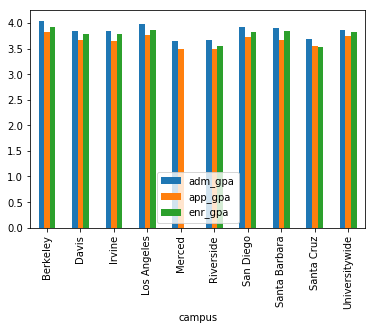

In [40]:
def avg_gpa_finder(data):
    d = {}
    d['adm_gpa'] = (data['adm_gpa'] * data['adm_num']).sum() / (data[data['adm_gpa'].notnull()]['adm_num'].sum())
    d['app_gpa'] = (data['app_gpa'] * data['app_num']).sum() / (data[data['app_gpa'].notnull()]['app_num'].sum())
    d['enr_gpa'] = (data['enr_gpa'] * data['enr_num']).sum() / (data[data['enr_gpa'].notnull()]['enr_num'].sum())
    return pd.Series(d, index=['adm_gpa', 'app_gpa', 'enr_gpa'])

packed.groupby(['campus']).apply(avg_gpa_finder).plot.bar()